# Visualization

This notebook demonstrate the experiment results:

- Distortion comparison between different embedding methods
- Running time comparison between different emebdding methods
- Distance reconstruction comparison (heatmap) between different embedding methods
- Visualization of KL embedding

In [1]:
import logging

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import squareform

%matplotlib inline

## Distortion and running time comparison

#### load experiment results from local files

In [3]:
num_nodes = 64
embed_dims = [2, 5, 10, 20, 30, 40]
num_embed_dims = len(embed_dims)

embed_types = ['Euclidean', 'Hyperbolic', 'WassR2', 'WassR3', 'KL']
num_embed_types = len(embed_types)

loss_reg = np.zeros((num_embed_types, num_embed_dims, 10))
time_reg = np.zeros((num_embed_types, num_embed_dims, 8))

time_graphs = [1, 3, 5, 6, 7, 8, 9, 10]

embeddings = []
embed_distances = []

for graph_id in range(10):
    for i, embed_type in enumerate(embed_types):
        for j, embed_dim in enumerate(embed_dims):
            res = np.load('./results/scale_free_{}_{}_{}_{}.npz'.format(num_nodes, graph_id+1, embed_type, embed_dim))
            loss_history = res['loss']
            loss = loss_history[-1]
            loss_reg[i, j, graph_id] = loss
            
            if graph_id == 0 and embed_dim == 40:
                embeddings.append(res['embeddings'])
                embed_distances.append(res['embed_distances'])
            
for g, graph_id in enumerate(time_graphs):
    for i, embed_type in enumerate(embed_types):
        for j, embed_dim in enumerate(embed_dims):
            res = np.load('./results/scale_free_{}_{}_{}_{}.npz'.format(num_nodes, graph_id, embed_type, embed_dim))
            time_history = res['time']
            t = time_history[-1]
            time_reg[i, j, g] = t

#### Distortion comparison

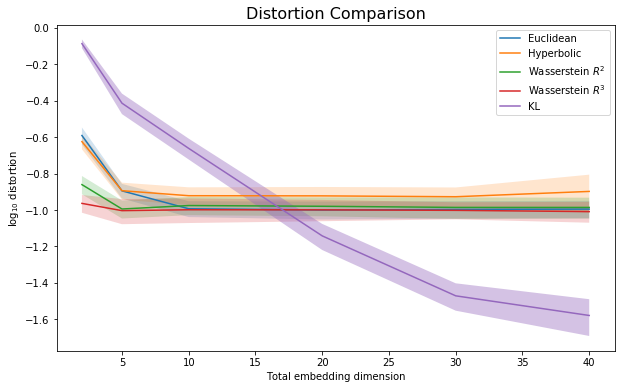

In [4]:
Euc_loss, Hyper_loss, WassR2_loss, WassR3_loss, KL_loss = loss_reg

mean_Euc_loss = np.mean(Euc_loss, axis=-1)
std_Euc_loss = np.std(Euc_loss, axis=-1)
upper_confidence_Euc = mean_Euc_loss + 1.96 * std_Euc_loss
lower_confidence_Euc = mean_Euc_loss - 1.96 * std_Euc_loss

mean_Hyper_loss = np.mean(Hyper_loss, axis=-1)
std_Hyper_loss = np.std(Hyper_loss, axis=-1)
upper_confidence_Hyper = mean_Hyper_loss + 1.96 * std_Hyper_loss
lower_confidence_Hyper = mean_Hyper_loss - 1.96 * std_Hyper_loss

mean_WassR2_loss = np.mean(WassR2_loss, axis=-1)
std_WassR2_loss = np.std(WassR2_loss, axis=-1)
upper_confidence_WassR2 = mean_WassR2_loss + 1.96 * std_WassR2_loss
lower_confidence_WassR2 = mean_WassR2_loss - 1.96 * std_WassR2_loss

mean_WassR3_loss = np.mean(WassR3_loss, axis=-1)
std_WassR3_loss = np.std(WassR3_loss, axis=-1)
upper_confidence_WassR3 = mean_WassR3_loss + 1.96 * std_WassR3_loss
lower_confidence_WassR3 = mean_WassR3_loss - 1.96 * std_WassR3_loss

mean_KL_loss = np.mean(KL_loss, axis=-1)
std_KL_loss = np.std(KL_loss, axis=-1)
upper_confidence_KL = mean_KL_loss + 1.96 * std_KL_loss
lower_confidence_KL = mean_KL_loss - 1.96 * std_KL_loss

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(embed_dims, np.log10(mean_Euc_loss), label='Euclidean')
ax.fill_between(embed_dims, np.log10(upper_confidence_Euc), np.log10(lower_confidence_Euc), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_Hyper_loss), label='Hyperbolic')
ax.fill_between(embed_dims, np.log10(upper_confidence_Hyper), np.log10(lower_confidence_Hyper), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_WassR2_loss), label='Wasserstein $R^2$')
ax.fill_between(embed_dims, np.log10(upper_confidence_WassR2), np.log10(lower_confidence_WassR2), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_WassR3_loss), label='Wasserstein $R^3$')
ax.fill_between(embed_dims, np.log10(upper_confidence_WassR3), np.log10(lower_confidence_WassR3), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_KL_loss), label='KL')
ax.fill_between(embed_dims, np.log10(upper_confidence_KL), np.log10(lower_confidence_KL), alpha=0.4)
ax.set_xlabel('Total embedding dimension')
ax.set_ylabel('$\log_{10}$ distortion')
ax.set_title('Distortion Comparison', fontsize=16)
ax.legend(loc='best')

#### Running time comparison

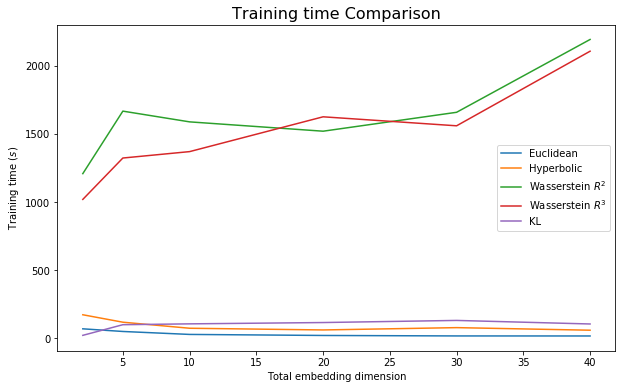

In [5]:
Euc_time, Hyper_time, WassR2_time, WassR3_time, KL_time = time_reg

mean_Euc_time = np.mean(Euc_time, axis=-1)
mean_Hyper_time = np.mean(Hyper_time, axis=-1)
mean_WassR2_time = np.mean(WassR2_time, axis=-1)
mean_WassR3_time = np.mean(WassR3_time, axis=-1)
mean_KL_time = np.mean(KL_time, axis=-1)

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(embed_dims, mean_Euc_time, label='Euclidean')
ax.plot(embed_dims, mean_Hyper_time, label='Hyperbolic')
ax.plot(embed_dims, mean_WassR2_time, label='Wasserstein $R^2$')
ax.plot(embed_dims, mean_WassR3_time, label='Wasserstein $R^3$')
ax.plot(embed_dims, mean_KL_time, label='KL')
ax.set_xlabel('Total embedding dimension')
ax.set_ylabel('Training time ($s$)')
ax.set_title('Training time Comparison', fontsize=16)
ax.legend(loc='best')

## Distance reconstruction

### Synthetic scale-free networks

#### Load a graph and the target distances

In [6]:
# visualize the embedding distance results by heatmap for graph 1 and embedding dimension 40
from graph_generator import GraphGenerator

g = nx.read_gpickle("./graphs/scale_free_64_1.pickle")
node_pairs = g.get_node_pairs()
obj_distances = g.get_obj_distances()

#### Plot distances in Heatmap

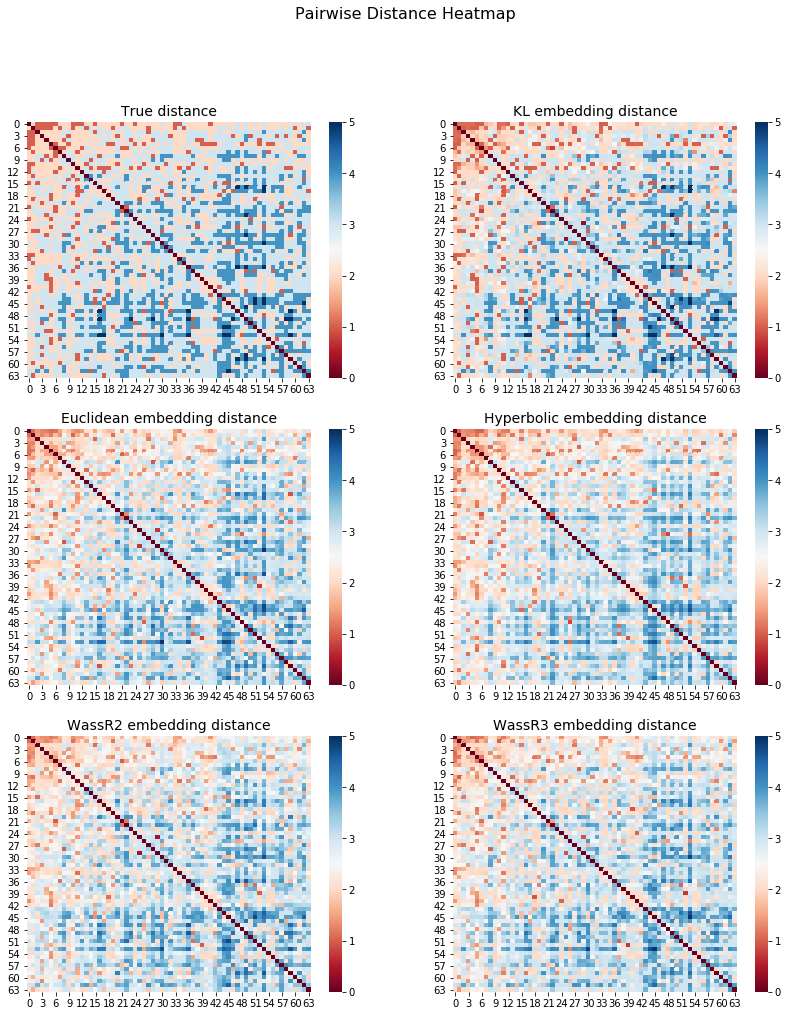

In [7]:
fig = plt.figure(figsize=(14, 16))
fig.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = squareform(obj_distances)
ax = plt.subplot(321)
ax.set_title('True distance', fontsize=14)
sns.heatmap(true_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

for i, _ in enumerate(embed_types):
    pred_distance = squareform(embed_distances[(i+4)%5])
    ax = plt.subplot(322+i)
    ax.set_title(embed_types[(i+4)%5] + " embedding distance", fontsize=14)
    sns.heatmap(pred_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

### Sales weekly transaction dataset

#### Load target distances (pre-computed DTW distances between series)

In [3]:
org_distances = np.loadtxt('./data/Sales_Transaction_Dataset.dist', delimiter=',')

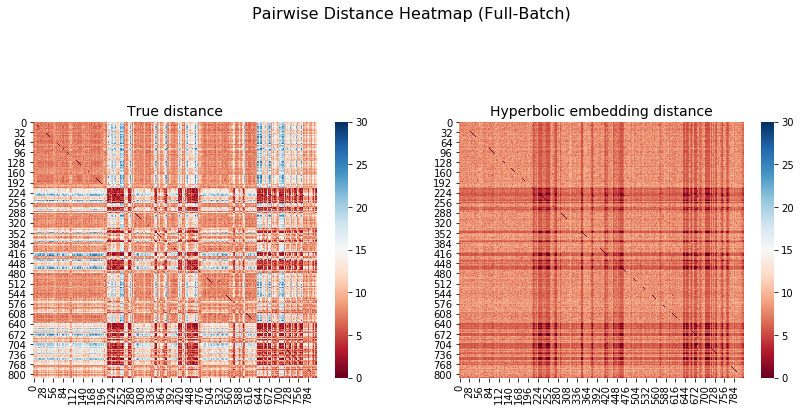

In [5]:
fig = plt.figure(figsize=(14, 16))
plt.suptitle("Pairwise Distance Heatmap (Full-Batch)", fontsize=16)

true_distance = org_distances
ax = plt.subplot(321)
ax.set_title('True distance', fontsize=14)
sns.heatmap(true_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

embed_type = 'Hyperbolic'
embed_dim = 30
# for i, embed_type in enumerate(embed_types):
pred_distances = np.load('./results/Sales_{}_{}_batch_adj2.npz'.format(embed_type, embed_dim))['embed_distances']
pred_distances = squareform(pred_distances)
ax = plt.subplot(322)
ax.set_title(embed_type + " embedding distance", fontsize=14)
sns.heatmap(pred_distances, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

#### Plot embedding distances obtained by full-batch optimization

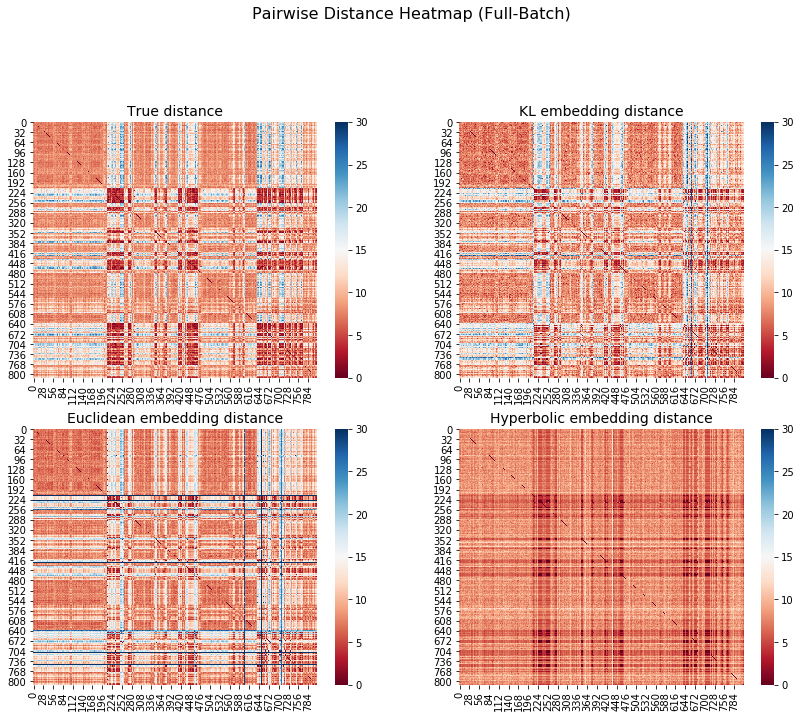

In [9]:
fig = plt.figure(figsize=(14, 16))
plt.suptitle("Pairwise Distance Heatmap (Full-Batch)", fontsize=16)

true_distance = org_distances
ax = plt.subplot(321)
ax.set_title('True distance', fontsize=14)
sns.heatmap(true_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

embed_types = ['KL', 'Euclidean', 'Hyperbolic']
embed_dim = 30
for i, embed_type in enumerate(embed_types):
    pred_distances = np.load('./results/Sales_{}_{}_full.npz'.format(embed_type, embed_dim))['embed_distances']
    pred_distances = squareform(pred_distances)
    ax = plt.subplot(322+i)
    ax.set_title(embed_type + " embedding distance", fontsize=14)
    sns.heatmap(pred_distances, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

#### Plot embedding distances obtained by mini-batch optimization

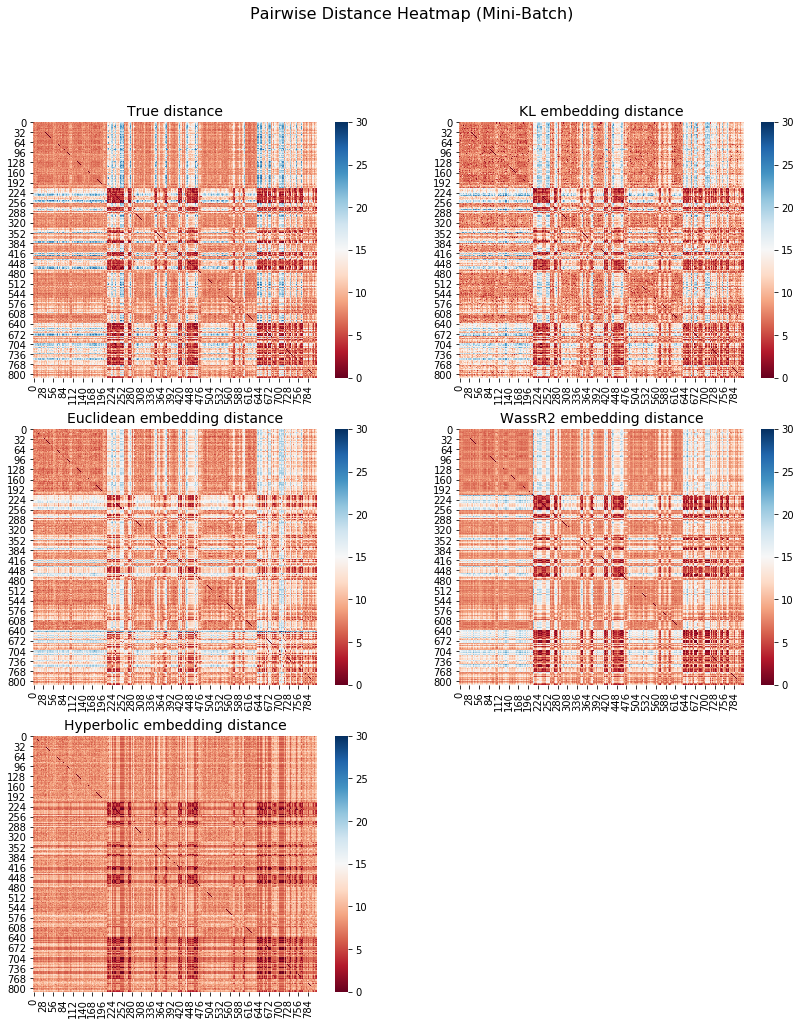

In [10]:
fig = plt.figure(figsize=(14, 16))
plt.suptitle("Pairwise Distance Heatmap (Mini-Batch)", fontsize=16)

true_distance = org_distances
ax = plt.subplot(321)
ax.set_title('True distance', fontsize=14)
sns.heatmap(true_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

embed_types = ['KL', 'Euclidean', 'WassR2', 'Hyperbolic']
embed_dim = 30
for i, embed_type in enumerate(embed_types):
    pred_distances = np.load('./results/Sales_{}_{}_batch.npz'.format(embed_type, embed_dim))['embed_distances']
    pred_distances = squareform(pred_distances)
    ax = plt.subplot(322+i)
    ax.set_title(embed_type + " embedding distance", fontsize=14)
    sns.heatmap(pred_distances, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

## KL embedding visualization

#### Load data from local files

In [11]:
org_distances = np.loadtxt('./data/Sales_Transaction_Dataset.dist', delimiter=',')

In [12]:
kl_results = np.load('./results/Sales_KL_30_full.npz')
kl_embeddings = kl_results['embeddings']
kl_distances = kl_results['embed_distances']
kl_distances = squareform(kl_distances)

#### Select several series to visualize

In [13]:
select_nodes = [212, 636, 732, 413, 150,  89]
dists = [org_distances[select_nodes[0], n] for n in select_nodes]
dists

[0.0, 0.0, 2.0, 7.2, 10.14, 16.679999999999996]

#### Normalize probability distribution

In [14]:
distributions = kl_embeddings[select_nodes, :]
distributions -= distributions.min(axis=1, keepdims=True)
distributions /= distributions.sum(axis=1, keepdims=True)

#### Plot histograms

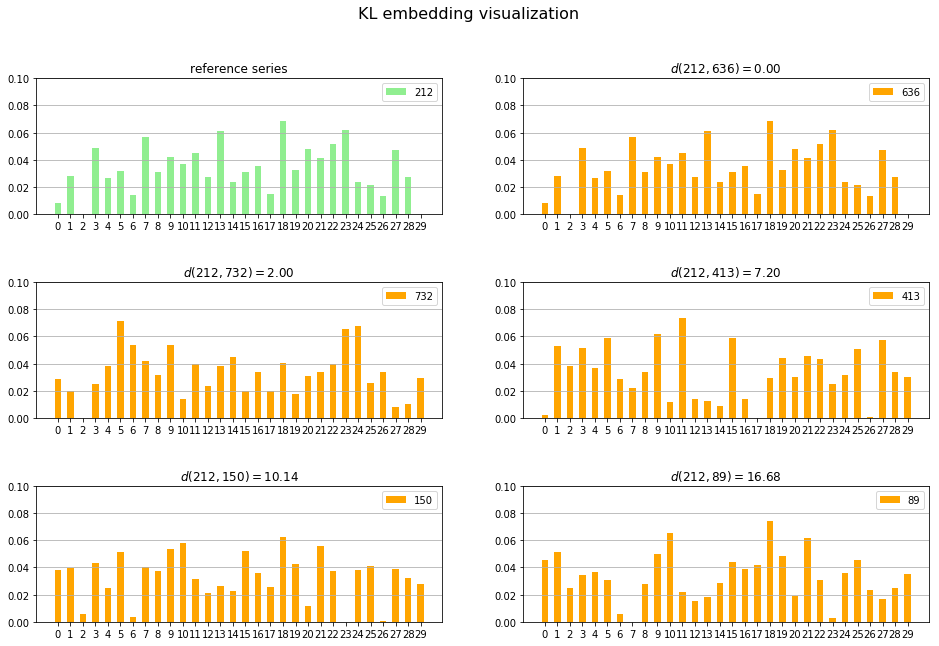

In [15]:
plt.figure(figsize=(16,10))

n_nodes, embed_dim = distributions.shape
ind = np.arange(embed_dim) 
width = 0.5
plt.subplot(321)
plt.bar(ind, distributions[0], width, label=select_nodes[0], color='lightgreen')
plt.ylim((0, 0.1))
plt.legend(loc='best')
plt.grid(axis='y')
plt.xticks(ind)
plt.title("reference series")

for i in range(1, n_nodes):
    plt.subplot(321 + i)
    plt.bar(ind, distributions[i], width, label=select_nodes[i], color='orange')
    plt.text
    plt.ylim((0, 0.1))
    plt.legend(loc='best')
    plt.grid(axis='y')
    plt.xticks(ind)
    plt.title("$d(212, {})={:.2f}$".format(select_nodes[i], dists[i]))

plt.suptitle("KL embedding visualization", fontsize=16)

plt.subplots_adjust(hspace=0.5)